In [17]:
import warnings
warnings.simplefilter("ignore") # disable Keras warnings for this tutorial

In [18]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [39]:
import numpy
from numpy import arange
import pandas as pd
from pandas import read_csv
from pandas import set_option
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers, preprocessing

In [40]:
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import datetime
from keras.models import load_model
from lime import lime_image
import numpy as np
from skimage.segmentation import mark_boundaries


In [42]:
print("keras {}".format(keras.__version__))
print("tensorflow {}".format(tf.__version__))

keras 2.8.0
tensorflow 2.8.0


In [43]:
tf.config.list_physical_devices('GPU')
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5732998748204283490
 xla_global_id: -1]

In [44]:
to_delete = True

if to_delete:

    num_skipped = 0
    for folder_name in ("training", "validation"):
        
        folder_path = os.path.join("ImagesPotholes", folder_name)
        
        for folder_name in ("cats", "dogs", 'normal', 'potholes'):
            folder_path_pet = os.path.join(folder_path, folder_name)
            
            for fname in os.listdir(folder_path_pet):
                
                fpath = os.path.join(folder_path_pet, fname)
                try:
                    fobj = open(fpath, "rb")
                    is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
                finally:
                    fobj.close()

                if not is_jfif:
                    num_skipped += 1
                    # Delete corrupted image
                    os.remove(fpath)

    print("Deleted %d images" % num_skipped)

Deleted 0 images


In [45]:

# Function to rename multiple files
def main(folder:str,split:str,pet:str, mode:str = 'int'):
   
    path = f"{folder}/{split}/{pet}"
    for count, filename in enumerate(os.listdir(path)):
        if mode == 'categorical':
            dst = f"{pet}_{str(count)}.jpg"
        if mode == 'int':
            dst = f"{str(count)}.jpg"

        src =f"{path}/{filename}"
        dst =f"{path}/{dst}"
         
        # rename() function will
        # rename all the files
        os.rename(src, dst)
 
# Driver Code
if __name__ == '__main__':
     
    # Calling main() function

    for split in ('training', 'validation'):
        for pet in ('cats', 'dogs', 'normal', 'potholes'):
            main(folder = 'ImagesPotholes', split = split, pet = pet, mode = 'int')

In [46]:
image_size = (180, 180)
batch_size = 32
seed = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "ImagesPotholes/training",
    validation_split=0.2,
    subset="training",
    labels='inferred',
    label_mode = 'categorical',
    color_mode ='rgb',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "ImagesPotholes/validation",
    validation_split=0.2,
    subset="validation",
    labels='inferred',
    label_mode = 'categorical',
    color_mode ='rgb',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

Found 276 files belonging to 4 classes.
Using 221 files for training.
Found 56 files belonging to 4 classes.
Using 11 files for validation.


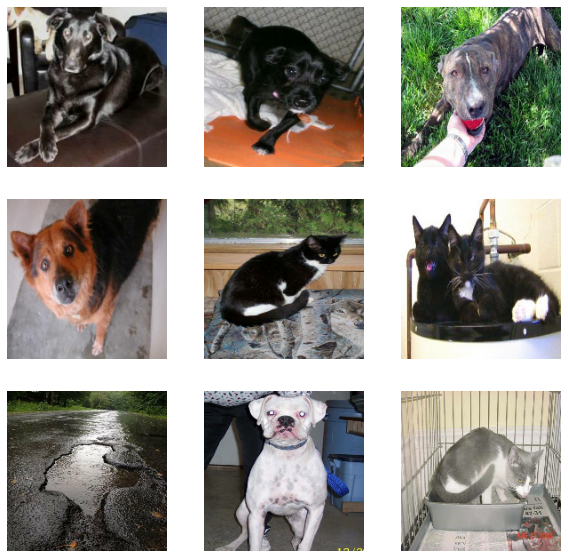

In [47]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(int(labels[i]))
        plt.axis("off")

In [48]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

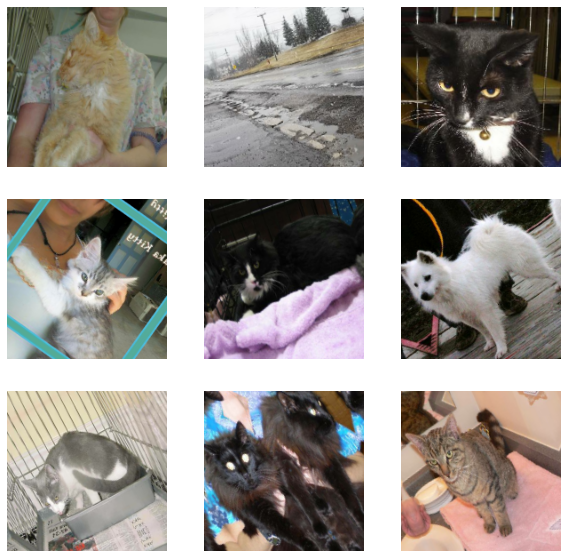

In [61]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

plt.figure(figsize=(10, 10))
for images, _ in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [62]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [63]:
def make_model(input_shape, num_classes):
    
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    # x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=4)

In [64]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("pothole_model_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


start = False

if start:

    model.fit(
        augmented_train_ds, epochs=epochs, callbacks=[callbacks, tensorboard_callback], validation_data=val_ds,
    )
    

In [117]:
image_size = (180, 180) 
batch_size = 32
seed = 42


loaded_model = tf.keras.models.load_model('pothole_model_10.h5')

path = "ImagesPotholes/validation/potholes/1.jpg"

img = keras.preprocessing.image.load_img(
    path, target_size=image_size
)


img_array = keras.preprocessing.image.img_to_array(img)
tf_img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = loaded_model.predict(tf_img_array)
score = [float(x) for x in predictions[0]]

print(
    "This image is {:.0%} percent cats, {:.0%} percent dogs, {:.0%} percent no-potholes, {:.0%} percent potholes".format(score[0], score[1], score[2], score[3])
)

This image is 3% percent cats, 1% percent dogs, 0% percent no-potholes, 95% percent potholes


In [118]:
explainer = lime_image.LimeImageExplainer()


img_lime = np.expand_dims(img_array, axis = 0)

explanation = explainer.explain_instance(img_lime[0].astype('double'), loaded_model.predict,  
                                         top_labels=3, hide_color=None, num_samples=500)

  0%|          | 0/500 [00:00<?, ?it/s]

(-0.5, 179.5, 179.5, -0.5)

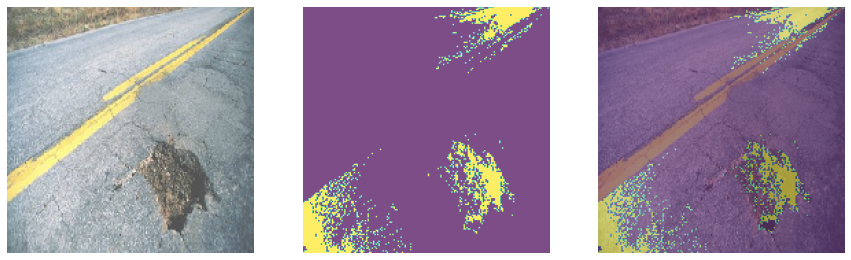

In [119]:

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=3, hide_rest=True)

img = keras.preprocessing.image.load_img(
    path, target_size=image_size
)

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,15))

ax1.imshow(img, alpha=0.7)
ax2.imshow(mask_1, alpha=0.7)
ax3.imshow(img, alpha=0.7)
ax3.imshow(mask_1, alpha=0.5)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')



# plt.savefig('potholes_prediction.png', transparent = True)
